# Image Captioning with Visual Attention- Medicat CT Images

Ref: https://www.tensorflow.org/tutorials/text/image_captioning

Brief steps:
1. Download the all.zip file containing the 5000 randomly sampled images
2. Download the Cleaned_CT_cluster_data_train.csv, Cleaned_CT_cluster_data_val.csv, and Cleaned_CT_cluster_data_test.csv from github. PATH: Image-Captioning-for-Medical-Images/data/CleanedCTMediCat/
3. Upload all the files above to Google drive
4. Open notebook in Colab 
5. Mount Drive and uploat surf.png and test-1.png (uploaded to GitHub)
6. Go to runtime -> Change runtime type -> Select "GPU" under Hardware Accelerator. Otherwise training takes too long. Colab sometimes may not provide a GPU (happened too many times with me) then training can take up to a few hours.
7. Change paths (variable name: path or [name].path) wherever needed
 

## Setup

In [1]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 5 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 13s (34.0 MB/s)
(Reading database ... 124015 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.1.1.33-1+cuda11.2 to

In [2]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Successfully uninstalled tensorflow-2.9.2
Found existing installation: keras 2.9.0
Uninstalling keras-2.9.0:
  Successfully uninstalled keras-2.9.0


In [3]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 28.6 MB/s 
     |████████████████████████████████| 588.3 MB 18 kB/s 
     |████████████████████████████████| 4.7 MB 30.4 MB/s 
     |████████████████████████████████| 1.7 MB 59.7 MB/s 
     |████████████████████████████████| 6.0 MB 46.9 MB/s 
     |████████████████████████████████| 439 kB 74.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  At

In [4]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 533 kB/s 


In [5]:
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

## Unzip Files

In [6]:
# !unzip /content/drive/MyDrive/Medicat/images/all.zip -d /content/drive/MyDrive/Medicat/images/all

^ need to run something like the cell above. syntax: `!unzip <path to all.zip file> -d <directory name to be extracted to>`

The all.zip file contains training + val + test images

## Reading the data

The aim here was to *retain* the format of all inputs as per the tensorflow tutorial.

In [7]:
import pandas as pd

train_path = "/content/drive/MyDrive/Medicat/captions/Cleaned_CT_cluster_data_train.csv" # change paths here 
val_path = "/content/drive/MyDrive/Medicat/captions/Cleaned_CT_cluster_data_val.csv"
test_path = "/content/drive/MyDrive/Medicat/captions/Cleaned_CT_cluster_data_test.csv"

train_df = pd.read_csv(train_path) 
val_df = pd.read_csv(val_path) 
test_df = pd.read_csv(test_path) 

In [8]:
train_df = train_df[:3230] # weird bug here, need to investigate. Considering the entire training dataset or >3230 results in an error

In [9]:
def caption_to_figure(caption_dict): # Get entire figure name 
    figure_file_name = '_'.join([caption_dict['pdf_hash'], caption_dict['fig_uri']])
    return figure_file_name

In [10]:
def get_file_names(df):
  return [caption_to_figure(caption_dict) for caption_dict in [df.iloc[i] for i in range(df.shape[0])]]

In [11]:
# val_file_names =  [caption_to_figure(caption_dict) for caption_dict in [val_df.iloc[i] for i in range(val_df.shape[0])]]

In [12]:
train_file_names = get_file_names(train_df)
val_file_names = get_file_names(val_df)
test_file_names = get_file_names(test_df)

In [13]:
len(train_file_names), len(val_file_names), len(test_file_names) # check

(3230, 1005, 495)

In [14]:
train_captions = train_df["cleaned_text"].tolist()
val_captions = val_df["cleaned_text"].tolist()
test_captions = test_df["cleaned_text"].tolist()

In [15]:
len(train_captions), len(val_captions), len(val_captions) # check

(3230, 1005, 1005)

In [16]:
def get_cap_dict(file_names, captions):
  cap_dict = collections.defaultdict(list)
  for fname, cap in zip(file_names, captions):
    cap_dict[fname].append(cap)
  
  return cap_dict

In [17]:
cap_dict_train = get_cap_dict(train_file_names, train_captions)
cap_dict_val = get_cap_dict(val_file_names, val_captions)
cap_dict_test = get_cap_dict(test_file_names, test_captions)

In [18]:
path = "/content/drive/MyDrive/Medicat/images/all"

for fname in train_file_names[:4]:
  print(f"{path}/{fname}") # check

/content/drive/MyDrive/Medicat/images/all/3946551731e42b03d03e16f8afc5a515288686fc_3-Figure1-1.png
/content/drive/MyDrive/Medicat/images/all/080948c9d4a1a2e233b446acc0329db4dbba6ca3_6-Figure2-1.png
/content/drive/MyDrive/Medicat/images/all/107226a3b3aefd96b88a28c31cdb68c9038bce40_2-Figure1-1.png
/content/drive/MyDrive/Medicat/images/all/4a23489f0f009917588567c905db9eebec6b84a8_2-Figure1-1.png


In [19]:
train_captions = [(f"{path}/{fname}", cap_dict_train[fname]) for fname in train_file_names] # store as (full path to img, caption)
val_captions = [(f"{path}/{fname}", cap_dict_val[fname]) for fname in val_file_names]
test_captions = [(f"{path}/{fname}", cap_dict_test[fname]) for fname in test_file_names]

In [20]:
test_captions[:2] # check

[('/content/drive/MyDrive/Medicat/images/all/7724836dbadfbd8417aa0cf63debb5776da9283f_2-Figure3-1.png',
  ['fig  3 postcontrast ct scan level gallbladder  v  demonstrates gallbladder parietal thickening  white arrow   highattenuation stone within gallbladder lumen  black arrow   pericholecystic abscess peripheral contrast enhancement  arrowhead   dilation distal segment common bile duct may seen  asterisk  ']),
 ('/content/drive/MyDrive/Medicat/images/all/4f4fbd23b9e6ddea409cc4df6df0f2456127ca6e_2-Figure2-1.png',
  ['figure 2 pelvic mass examined computed tomography  ct   ct examination revealed welldefined mass posterior uterine region  considered fibroid steatosis '])]

In [21]:
train_captions[:2] #check

[('/content/drive/MyDrive/Medicat/images/all/3946551731e42b03d03e16f8afc5a515288686fc_3-Figure1-1.png',
  ['figure 1 objective image finding first visit institute   egd finding treatment  egd found protruding lesion  20 mm diameter  gastric cardia  b  abdominal ct contrast treatment  ct showed multiple mass lesion throughout liver  arrow   egd  esophagogastroduodenoscopy  ct  computed tomography ']),
 ('/content/drive/MyDrive/Medicat/images/all/080948c9d4a1a2e233b446acc0329db4dbba6ca3_6-Figure2-1.png',
  ['figure 2  a scrofuloderma  courtesy dr vitor paulo perez  fiocruz   b chest xray posterioranterior  pa  position showing right infraclavicular opacity  red arrow   image thickwalled cavity  acinar lesion permeating left superior lobe  blue arrow  pleural effusion left  yellow arrow   pulmonary tuberculosis – chest xray patient figure 3  courtesy dr vitor paulo perez  fiocruz   c scrofuloderma  courtesy dra  julia ocampo lyra da silva – bonsucesso federal hospital   d scrofuloderma  u

In [22]:
train_raw = tf.data.experimental.from_list(train_captions) 
val_raw = tf.data.experimental.from_list(val_captions)
test_raw = tf.data.experimental.from_list(test_captions)

In [23]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(1,), dtype=tf.string, name=None))

In [24]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'/content/drive/MyDrive/Medicat/images/all/3946551731e42b03d03e16f8afc5a515288686fc_3-Figure1-1.png', shape=(), dtype=string)
tf.Tensor([b'figure 1 objective image finding first visit institute   egd finding treatment  egd found protruding lesion  20 mm diameter  gastric cardia  b  abdominal ct contrast treatment  ct showed multiple mass lesion throughout liver  arrow   egd  esophagogastroduodenoscopy  ct  computed tomography '], shape=(1,), dtype=string)


In [25]:
val_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(1,), dtype=tf.string, name=None))

In [26]:
test_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(1,), dtype=tf.string, name=None))

## Image Feature Extractor

Pretrained on ImageNet. The model was trained as an image classifier, but setting include_top=False returns the model without the final classification layer, so you can use the last layer of feature-maps.

In [27]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False, # remove classification layer
    include_preprocessing=True)
mobilenet.trainable=False

4334752/4334752 [==============================] - 0s 0us/step


Load and resize the image for model

In [28]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3) # works even when the images are png?
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

Model returns a feature map for each image

In [29]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


In [30]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

## Tokenizer/ vectorizer setup

Steps:

- Use adapt to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
- Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
- Create word-to-index and index-to-word mappings to display results.

In [31]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [32]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [33]:
tokenizer.get_vocabulary()[:10]

['',
 '[UNK]',
 'ct',
 '[START]',
 '[END]',
 'b',
 'arrow',
 'tomography',
 'scan',
 'computed']

In [34]:
t = tokenizer([['a ct image'], ['another ct image']])
t

<tf.RaggedTensor [[3, 241, 2, 16, 4],
 [3, 706, 2, 16, 4]]>

In [35]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [36]:
w = index_to_word(t)
w.to_list()


[[b'[START]', b'a', b'ct', b'image', b'[END]'],
 [b'[START]', b'another', b'ct', b'image', b'[END]']]

In [37]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a ct image [END]', b'[START] another ct image [END]'],
      dtype=object)

The train_raw and test_raw datasets contain 1:many (image, captions) pairs.

This function will replicate (problematic?) the image so there are 1:1 images to captions:

In [38]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [39]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)

image paths: (32,)
captions: (32, 1)

image_paths: (32,)
captions: (32,)


This function will convert an (images, texts) pair to an ((images, input_tokens), label_tokens) pair:

In [40]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the image, caption pairs.
4. Tokenize the text, shift the tokens and add label_tokens.
5. Convert the text from a RaggedTensor representation to padded dense Tensor representation.

In [41]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(7000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [42]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [43]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [44]:
val_ds = prepare_dataset(val_raw, tokenizer)
val_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [45]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)

  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [46]:
'''

Note: 
saving dataset to cache can help speed up the process for FLICKR
this is because we had to download the FLICKR8K dataset from a url
however, we already have the dataset locally
we may not need this code (please verify)

'''
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer) 
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)
save_dataset(val_raw, 'val_cache', mobilenet, tokenizer)

101it [15:40,  9.31s/it]
16it [02:23,  9.00s/it]
32it [04:48,  9.02s/it]


In [47]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')
val_ds = load_dataset('val_cache')

In [48]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [49]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 72)
(32, 72)


In [50]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   3   10   29 2588  217 2866 1418  721 1517   18  381   33    1   23
    1   78    5 4243  474  118  146  791  639   95   13   35   25   23
    2  467   22   87  157   17 1197  261 4547  474  110   70   47  271
  112    6 2114  524  284  276    6   30  521 3114  388 3172  182 1739
    1    1  789 1143  103    2    1 3628  108    1  582  291    0    0
    0    0]
[  10   29 2588  217 2866 1418  721 1517   18  381   33    1   23    1
   78    5 4243  474  118  146  791  639   95   13   35   25   23    2
  467   22   87  157   17 1197  261 4547  474  110   70   47  271  112
    6 2114  524  284  276    6   30  521 3114  388 3172  182 1739    1
    1  789 1143  103    2    1 3628  108    1  582  291    4    0    0
    0    0]


# Transformer Decoder

2-layer transformer decoder

The model will be implemented in three main parts:

1. Input - The token embedding and positional encoding (SeqEmbedding).
2. Decoder - A stack of transformer decoder layers (DecoderLayer) where each contains:
- A causal self attention later (CausalSelfAttention), where each output location can attend to the output so far.
- A cross attention layer (CrossAttention) where each output location can attend to the input image.
- A feed forward network (FeedForward) layer which further processes each output location independently.
3. Output - A multiclass-classification over the output vocabulary.

In [51]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

In [52]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

In [53]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [54]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

In [55]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

In [56]:
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x) #### The comments below are not from me. They are from the tutorial-> need to investigate
    # TODO(b/250038731): Fix this. 
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias

In [57]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 101/101 [00:00<00:00, 158.11it/s]


Uniform entropy: 8.52
Marginal entropy: 6.49


Build the model
To build the model, you need to combine several parts:

1. The image feature_extractor and the text tokenizer and.
2. The seq_embedding layer, to convert batches of token-IDs to vectors (batch, sequence, channels).
3. The stack of DecoderLayers layers that will process the text and image data.
4. The output_layer which returns a pointwise prediction of what the next word should be.

In [58]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=100, num_heads=1, dropout_rate=0.1): # change max length from 50
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [59]:
@Captioner.add_method
def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))

    txt = self.output_layer(txt)

    return txt

In [60]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

In [61]:
image_path = "surf.png" # took a training sample and named it "surf"
image = load_image(image_path)

In [62]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [63]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)


figure ct
magnetic right hematoma small posterior asterisk arterial ct pet low computed tissue insufficient left increased side cavity chemotherapy 1 left mass 3


In [64]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

In [67]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    # image_url = 'https://tensorflow.org/images/surf.jpg'
    # image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    image_path = "surf.png" # same random training image attached
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()

In [68]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)




computed showed ct scan show left b scan lung ct b arrow b scan figure figure left chest 1 fig showing left b left cavity abdominal b multiple arrow tomography ct b ct tomography left arrow arrow chest showing ct c arrow tomography venous 1
attenuation right



In [69]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

# Compiling and Training the Model

In [70]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # is this lr too low?
           loss=masked_loss,
           metrics=[masked_acc])

In [71]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=val_ds.repeat(), # changed to val ds from test ds
    validation_steps=20,
    epochs=100, 
    callbacks=callbacks)

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 6.2746 - masked_acc: 0.0910

figure 1 computed tomography ct scan showing showing showing showing right b ct scan showing b ct scan show
figure 1 scan computed tomography scan showing pleural c ct scan ct scan 2 xray artery left right c scan showing left arrow
figure 1 distributed ct head showed 9 left documented bcell left 64yearold b surrounding larger 3 invaded drainage mip protocol late ct scan presented omental 2 sacrum view cm arrow increasing effect therapy aggravated pulmonary show 1 effusion view inferior arrow inflammatory tumor plain left showing arrow excised carcinoma

100/100 [==============================] - 44s 312ms/step - loss: 6.2721 - masked_acc: 0.0912 - val_loss: 5.8751 - val_masked_acc: 0.1188
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 5.9356 - masked_acc: 0.1224

figure 1 computed tomography ct scan showing right lung b ct scan showing b ct scan showing right lung

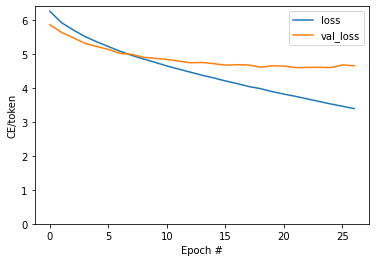

In [72]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token') # cross entropy loss per token?
plt.legend()

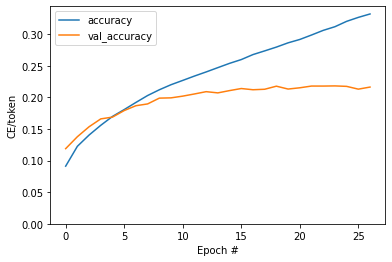

In [73]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

The model seems to be overfitting, need more dropout layers/ other regularization?

In [74]:
result = model.simple_gen(image, temperature=0.0)
result

'figure 1 positron emission tomographycomputed tomography scan showing multiple nodule right adrenal gland b petct scan showing multiple liver lesion c'

In [75]:
str_tokens = result.split()
str_tokens.append('[END]')

In [76]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 22, 49]), TensorShape([1, 2, 22, 49])]

In [77]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

In [78]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(22,), dtype=float32, numpy=
array([1.        , 1.        , 1.        , 1.        , 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)>

# Visually Representing the Results

In [93]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/3)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)]) # TO DO: better plot layout

    plt.tight_layout()

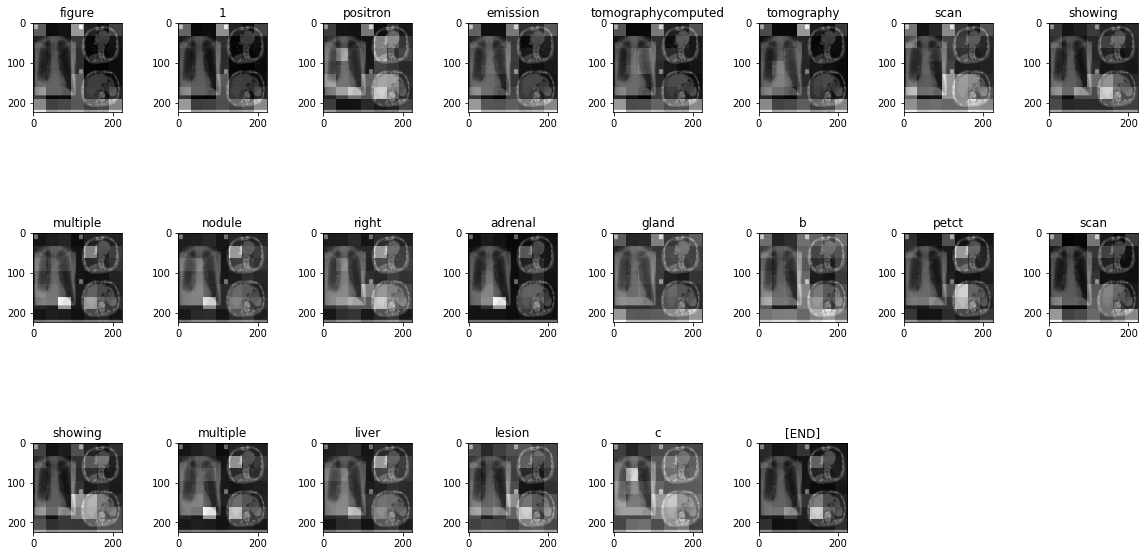

In [94]:
plot_attention_maps(image/255, str_tokens, attention_maps)

In [95]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')

  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)

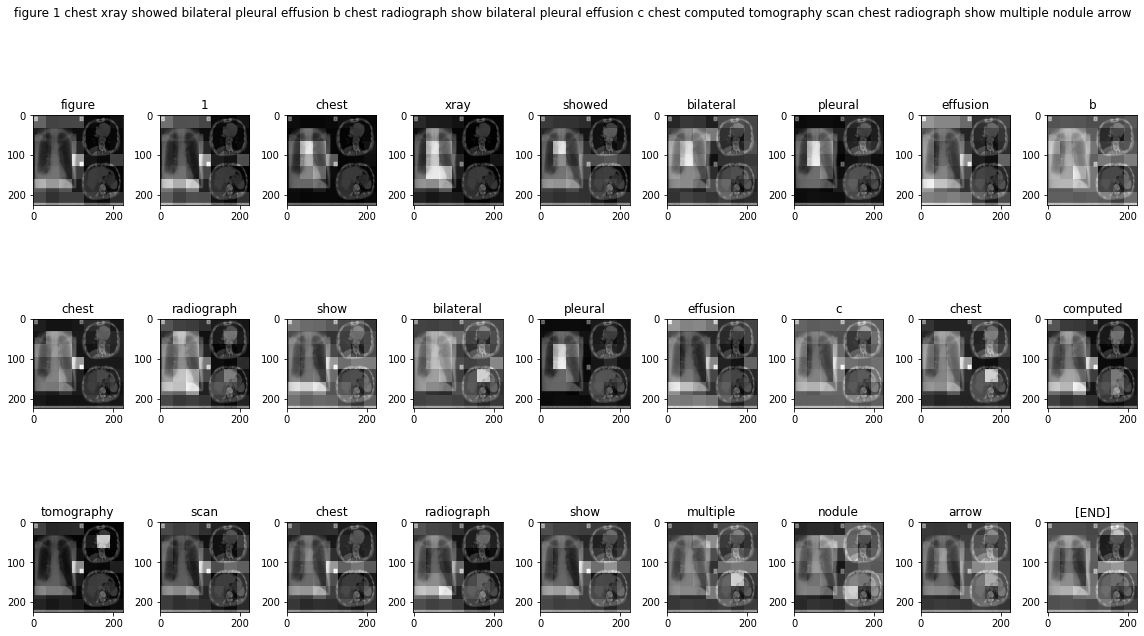

In [96]:
image_path = "test-1.png"
image = load_image(image_path)
run_and_show_attention(model, image)

chest x-ray part and CT part seems to be identified correctly

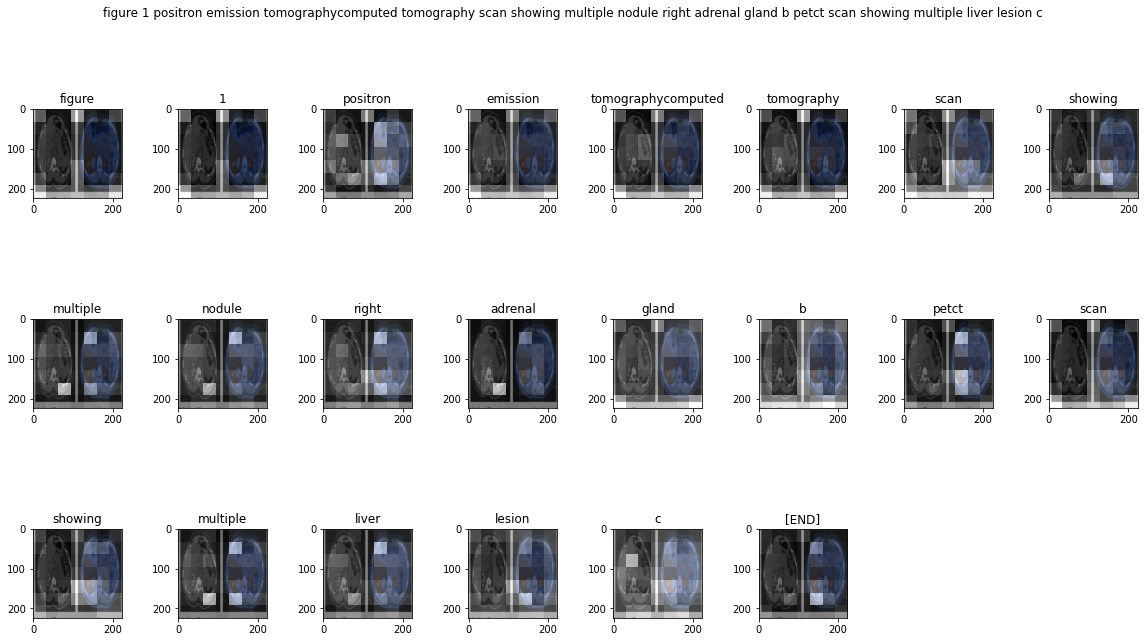

In [97]:
image_path = "surf.png"
image = load_image(image_path)
run_and_show_attention(model, image)

**TO DOs:**
- Evaluate on training data
- Potentially save this and finetune
- Train on Medicat MRI
- **BLEU/ other metrics**

Notes:
- Preprocessing steps are different for images, need to incorporate steps from the report
- I am unable to save the model and run it, not sure why but the results seem mostly consistent
- I could not use the entire training dataset (only 3230 values, not sure why I get an error when I use all the data) -> I speculate this has to do with me having only 4999 images and not 5000. I tried running code to check if I was missing any images but was unsuccessful in both finding which image I am missing and the cause for the bug.
- I retained ImageNet pretraining in the end, perhaps we need to do a few more experiments to justify/ remove it altogether 